In [ ]:
# Install torch geometric
# %pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
# %pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
# %pip install -q torch-geometric

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


You can explore more PyG functions through its [documentation](https://pytorch-geometric.readthedocs.io/en/latest/).

# Visualization

In [1]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

# Introduction

Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregularly structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to simplify the implementation of Graph Neural Networks.

Following [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

# Dataset

In [2]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

c:\Users\Hi\miniconda3\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 지정된 프로시저를 찾을 수 없습니다
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Hi\miniconda3\Lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] 지정된 프로시저를 찾을 수 없습니다
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
c:\Users\Hi\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [3]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


# Datat

Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes:
```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```
We can see that this `data` object holds 4 attributes:
(1) The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
PyG further refers to (2) **node features** as `x` (each of the 34 nodes is assigned a 34-dim feature vector), and to (3) **node labels** as `y` (each node is assigned to exactly one class).
(4) There also exists an additional attribute called `train_mask`, which describes for which nodes we already know their community assigments.
In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

The `data` object also provides some **utility functions** to infer some basic properties of the underlying graph.
For example, we can easily infer whether there exists isolated nodes in the graph (*i.e.* there exists no edge to any node), whether the graph contains self-loops (*i.e.*, $(v, v) \in \mathbb{E}$), or whether the graph is undirected (*i.e.*, for each edge $(v, w) \in \mathbb{E}$ there also exists the edge $(w, v) \in \mathbb{E}$).

PyTorch Geometric에서 각 그래프는 [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) 객체로 표현되며, 이 객체는 그래프 표현을 설명하는 데 필요한 모든 정보를 담고 있습니다. `print(data)`를 사용하여 언제든지 `data` 객체를 출력하면, 속성과 그 형태에 대한 간단한 요약 정보를 볼 수 있습니다.

```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```

이 `data` 객체는 4개의 속성을 포함하고 있습니다:
1. `edge_index` 속성은 **그래프 연결성** 정보를 포함하며, 각 엣지에 대해 소스와 목적 노드의 인덱스를 나타내는 튜플입니다.
2. PyG는 (2) **노드 특성**을 `x`로 나타내며, 34개의 노드 각각에 34차원 특성 벡터가 할당됩니다. 
3. (3) **노드 레이블**은 `y`로 나타내며, 각 노드가 하나의 클래스에 할당됩니다.
4. 추가로 `train_mask`라는 속성이 있으며, 이 속성은 커뮤니티 할당을 이미 알고 있는 노드를 설명합니다.

전체적으로, 우리는 4개의 노드(각 커뮤니티마다 하나씩)의 실제 레이블만 알고 있으며, 나머지 노드의 커뮤니티 할당을 추론하는 것이 과제입니다.

`data` 객체는 기본적인 그래프 속성을 유추하는 데 도움이 되는 **유틸리티 함수**도 제공합니다. 예를 들어, 그래프에 고립된 노드(즉, 다른 노드와 연결된 엣지가 없는 경우)가 있는지, 그래프에 자기 루프(즉, $(v, v) \in \mathbb{E}$)가 포함되어 있는지, 그래프가 무방향인지(즉, 각 엣지 $(v, w) \in \mathbb{E}$에 대해 $(w, v) \in \mathbb{E}$도 존재하는지) 쉽게 확인할 수 있습니다.

In [4]:
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


# Edge Index

`edge_index`를 출력함으로써 PyG가 그래프 연결성을 내부적으로 어떻게 표현하는지 더 잘 이해할 수 있습니다. 각 엣지에 대해 `edge_index`는 두 개의 노드 인덱스로 이루어진 튜플을 포함하는데, 첫 번째 값은 소스 노드의 인덱스를 나타내고, 두 번째 값은 엣지의 목적 노드의 인덱스를 나타냅니다.

이러한 표현 방식은 **COO 형식(좌표 형식)**으로 알려져 있으며, 희소 행렬을 표현하는 데 일반적으로 사용됩니다. PyG는 그래프의 인접 정보를 조밀한 표현 $\mathbf{A} \in \{ 0, 1 \}^{|\mathbb{V}| \times |\mathbb{V}|}$ 대신 희소하게 표현합니다. 즉, $\mathbf{A}$의 값이 0이 아닌 항목의 좌표/값만을 저장합니다.

그래프를 `networkx` 라이브러리 형식으로 변환하여 시각화할 수도 있습니다. `networkx`는 그래프 조작 기능 외에도 강력한 시각화 도구를 제공합니다.

In [6]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

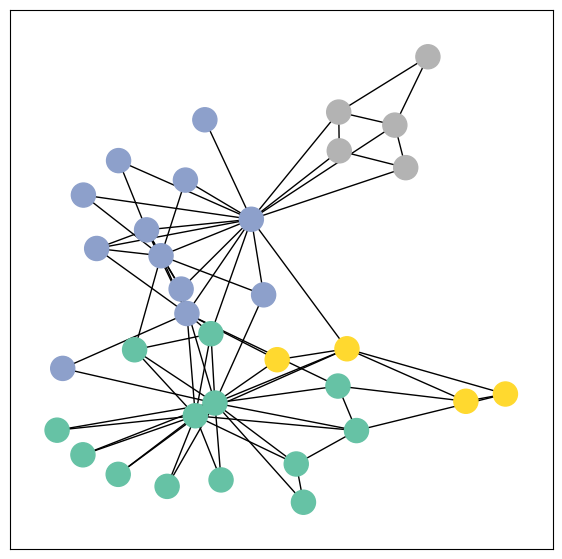

In [7]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

# Implementing Graph Neural Networks (GNNs)

PyG의 데이터 처리 방식을 이해한 후, 이제 첫 번째 그래프 신경망을 구현할 차례입니다!

이를 위해 가장 간단한 GNN 연산자 중 하나인 **GCN 레이어**([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907))를 사용할 것입니다.

PyG는 [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)를 통해 이 레이어를 구현하며, 노드 특성 표현 `x`와 COO 형식의 그래프 연결성 표현 `edge_index`를 전달함으로써 실행할 수 있습니다.

### GNN의 출력은 무엇인가?

GNN의 목표는 입력 그래프 $G = (\mathbb{V}, \mathbb{E})$를 받아들여, 각 노드 $v_i \in \mathbb{V}$가 입력 특성 벡터 $X_i^{(0)}$를 가지고 있을 때, $f_G : \mathbb{V} \times \mathbb{R}^{d_1} \to \mathbb{R}^{d_2}$라는 함수를 학습하는 것입니다. 이 함수는 노드와 그 특성 벡터, 그리고 그래프 구조를 입력으로 받아 _임베딩_을 출력합니다. 이 벡터는 해당 노드를 우리의 다운스트림 작업에 유용한 방식으로 표현합니다. 노드와 초기 특성을 학습된 임베딩으로 매핑한 후, 이 임베딩을 사용하여 노드 단위, 엣지 단위, 또는 그래프 단위의 회귀/분류 작업을 수행할 수 있습니다.

이제 우리는 각 노드를 그 커뮤니티에 따라 분류하는 데 유용한 임베딩을 학습하고자 하므로, 노드 단위 분류 문제를 다루고 있습니다.

이제 `torch.nn.Module` 클래스를 사용하여 네트워크 아키텍처를 정의함으로써 첫 번째 그래프 신경망을 만들 준비가 되었습니다.

In [9]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


여기서는 `__init__`에서 모든 구성 요소를 초기화하고, `forward`에서 네트워크의 연산 흐름을 정의합니다. 우리는 **세 개의 그래프 컨볼루션 레이어**를 정의하고 스택으로 쌓습니다. 각 레이어는 각 노드의 1-hop 이웃(즉, 직접 연결된 이웃)으로부터 정보를 집계하지만, 레이어들을 함께 구성함으로써 각 노드는 3-hop 이웃(최대 3개의 "도약" 거리 내의 모든 노드)으로부터 정보를 집계할 수 있습니다.

또한, `GCNConv` 레이어는 노드 특성의 차원을 $2$로 줄입니다. 즉, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$로 차원을 감소시킵니다. 각 `GCNConv` 레이어는 [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) 비선형 활성화 함수로 보강됩니다.

그 후, 우리는 단일 선형 변환([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear))을 적용하여 노드를 4개의 클래스/커뮤니티 중 하나로 매핑하는 분류기로 작동하게 합니다.

최종적으로, 우리는 GNN이 생성한 노드 임베딩과 최종 분류기의 출력을 반환합니다. 모델을 `GCN()`을 통해 초기화한 후, 모델을 출력하면 사용된 모든 서브 모듈에 대한 요약이 출력됩니다.

In [14]:
data.x.shape

torch.Size([34, 34])

In [18]:
data.edge_index.shape

torch.Size([2, 156])

Embedding shape: [34, 2]


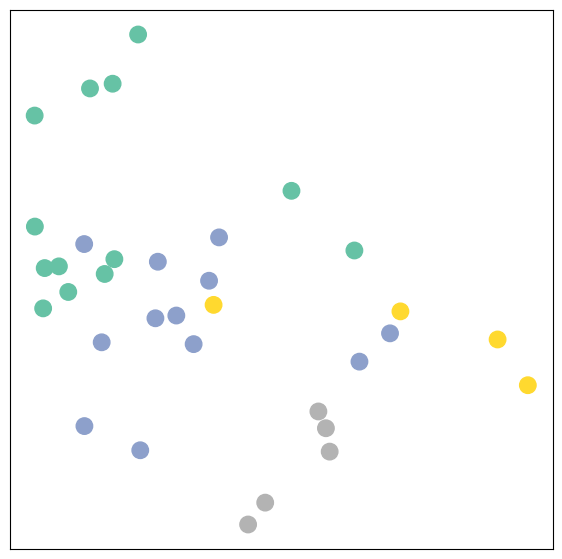

In [10]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

놀랍게도, 모델의 가중치를 학습하기 전에조차도 모델은 그래프의 커뮤니티 구조를 잘 나타내는 노드 임베딩을 생성합니다. 같은 색(커뮤니티)의 노드들이 이미 임베딩 공간에서 서로 가깝게 군집되어 있는데, 이는 모델의 가중치가 **완전히 무작위로 초기화**된 상태이며 아직 학습이 이루어지지 않았음에도 불구하고 나타나는 현상입니다! 이는 GNN이 강력한 귀납적 편향을 도입하여 입력 그래프에서 서로 가까운 노드에 대해 유사한 임베딩을 생성한다는 결론을 이끌어냅니다.

### Karate Club 네트워크에서의 학습

하지만 더 나아질 수 있을까요? 그래프의 4개의 노드(각 커뮤니티마다 하나)에 대한 커뮤니티 할당 정보를 바탕으로 네트워크 파라미터를 학습하는 예제를 살펴봅시다.

우리의 모델에서 모든 것이 미분 가능하고 파라미터화되어 있으므로, 일부 레이블을 추가하고 모델을 학습하여 임베딩이 어떻게 변화하는지 관찰할 수 있습니다. 여기서는 반지도 학습 또는 추론 학습 방식을 사용합니다. 우리는 각 클래스당 하나의 노드에 대해 학습하지만, 전체 입력 그래프 데이터를 사용할 수 있습니다.

모델을 학습하는 과정은 다른 PyTorch 모델과 매우 유사합니다. 네트워크 아키텍처를 정의한 후, 손실 기준(`CrossEntropyLoss`)을 정의하고, 확률적 경사 하강 최적화 기법(여기서는 `Adam` 최적화)을 초기화합니다. 그런 다음, 여러 번의 최적화를 수행하며, 각 최적화 라운드는 순전파와 역전파로 이루어져 손실에 대한 모델 파라미터의 기울기를 계산합니다. PyTorch에 익숙하다면 이 과정이 익숙할 것입니다. 그렇지 않다면, PyTorch 문서에 [신경망 학습에 대한 좋은 입문 자료](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer)가 있습니다.

반지도 학습 시나리오는 다음 코드 라인으로 구현됩니다:
```python
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
우리는 모든 노드에 대한 임베딩을 계산하지만, **손실을 계산할 때는 학습 노드만 사용합니다**. 여기서는 분류기 `out`의 출력과 실제 레이블 `data.y`를 `train_mask`에 있는 노드만 포함하도록 필터링하여 구현됩니다.

이제 학습을 시작하고, 시간이 지남에 따라 노드 임베딩이 어떻게 발전하는지 살펴봅시다(코드를 직접 실행해보면 더 잘 이해할 수 있습니다).

<IPython.core.display.Javascript object>

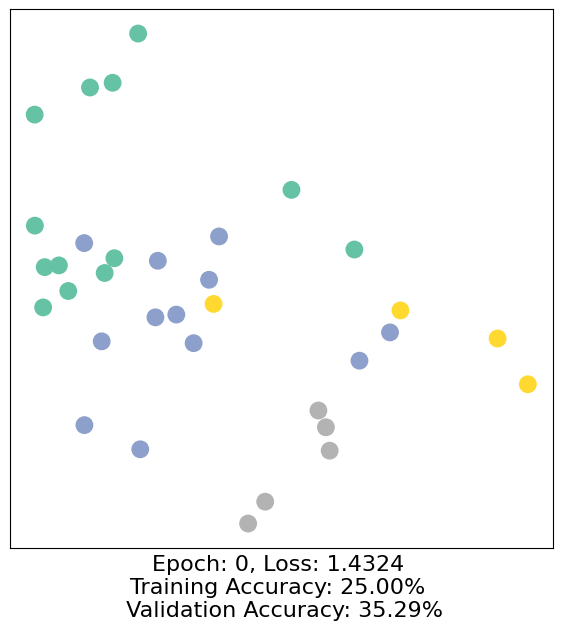

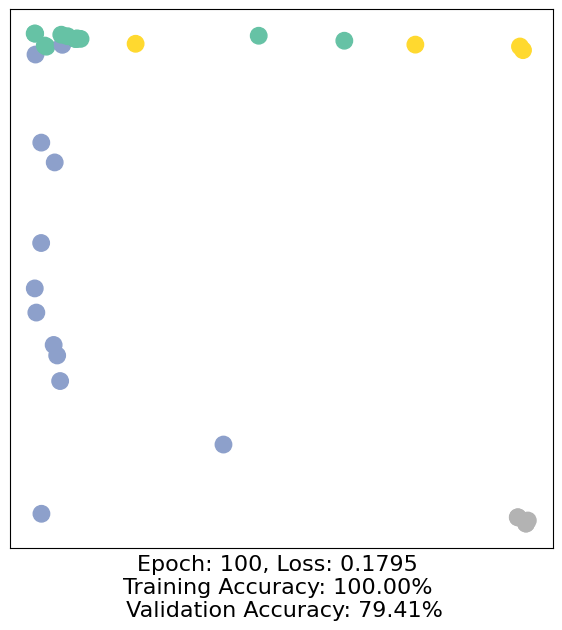

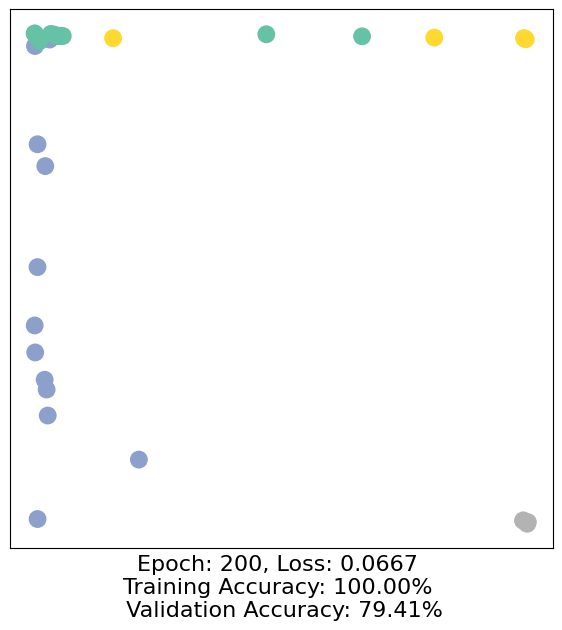

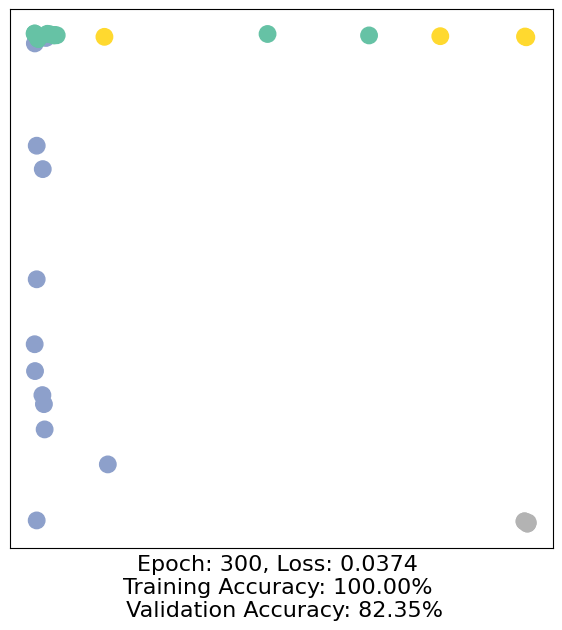

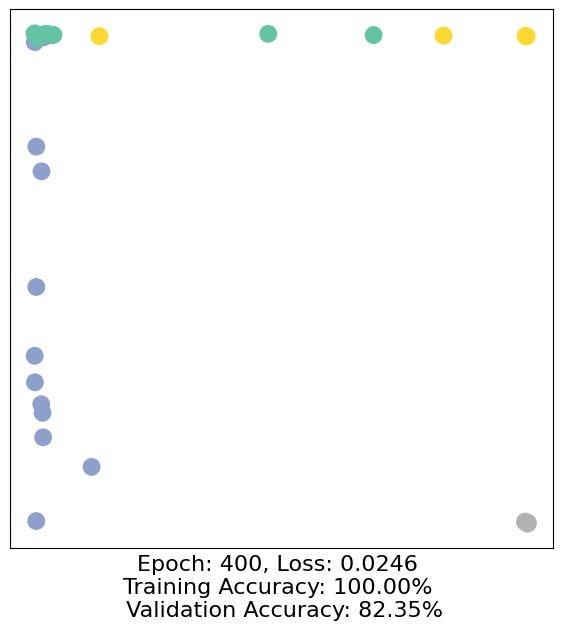

In [20]:
import time
from IPython.display import Javascript  # 출력 셀의 높이를 제한하기 위해 사용합니다.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()  # GCN 모델을 초기화합니다.
criterion = torch.nn.CrossEntropyLoss()  # 손실 기준을 정의합니다. (교차 엔트로피 손실 함수)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # 옵티마이저를 정의합니다. (Adam 최적화 알고리즘 사용, 학습률 0.01)

# 학습 함수 정의
def train(data):
    optimizer.zero_grad()  # 기울기를 초기화합니다.
    out, h = model(data.x, data.edge_index)  # 한 번의 순전파를 수행하여 출력과 임베딩을 계산합니다.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # 학습 노드에 대해서만 손실을 계산합니다.
    loss.backward()  # 손실을 기준으로 기울기를 계산합니다.
    optimizer.step()  # 기울기를 사용하여 모델의 파라미터를 업데이트합니다.

    accuracy = {}  # 정확도를 저장할 딕셔너리입니다.

    # 학습 정확도 계산 (4개의 학습 예제에 대해서)
    # `torch.argmax`는 각 노드에 대해 가장 높은 확률을 가진 클래스를 반환합니다.
    # 예: [0.6, 0.2, 0.7, 0.1] -> 2 (가장 높은 값의 인덱스)
    predicted_classes = torch.argmax(out[data.train_mask], axis=1)
    target_classes = data.y[data.train_mask]  # 학습 노드의 실제 클래스입니다.
    # 예측 클래스와 실제 클래스가 일치하는지 확인하여 정확도를 계산합니다.
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # 그래프 전체에 대한 검증 정확도 계산
    predicted_classes = torch.argmax(out, axis=1)  # 그래프의 모든 노드에 대해 예측 클래스를 계산합니다.
    target_classes = data.y  # 모든 노드의 실제 클래스입니다.
    # 예측 클래스와 실제 클래스가 일치하는지 확인하여 정확도를 계산합니다.
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy  # 손실, 노드 임베딩, 정확도를 반환합니다.

# 500번의 에포크 동안 모델을 학습합니다.
for epoch in range(500):
    loss, h, accuracy = train(data)  # 한 에포크 동안 학습을 수행합니다.
    # 매 10 에포크마다 노드 임베딩을 시각화합니다.
    if epoch % 100 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)  # 임베딩 시각화
        time.sleep(0.3)  # 0.3초 동안 대기하여 시각화를 볼 수 있도록 합니다.


As one can see, our 3-layer GCN model manages to separate the communities pretty well and classify most of the nodes correctly.

Furthermore, we did this all with a few lines of code, thanks to the PyTorch Geometric library which helped us out with data handling and GNN implementations.